In [1]:
import pandas as pd
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number, regexp_replace, sum, when, count, round as sparkrnd, max as sparkmax, min as sparkmin, year, avg as sparkavg, stddev as sparkstd
from pyspark.sql.functions import regexp_replace
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DateType

In [2]:
spark = SparkSession.builder.getOrCreate()

24/06/25 16:20:16 WARN Utils: Your hostname, dsbda-vm resolves to a loopback address: 127.0.1.1; using 192.168.64.2 instead (on interface enp0s1)
24/06/25 16:20:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/25 16:20:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/25 16:20:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/06/25 16:20:17 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
#Preparing tables for spark join

file_path_listings = "/home/ubuntu/DATASET/listings_details.csv"
file_path_reviews = "/home/ubuntu/DATASET/reviews_details.csv"


df_listings = spark.read.csv(file_path_listings, header=True, inferSchema=True, sep=",", quote= '"', escape= '"', multiLine=True, mode="DROPMALFORMED")
df_cleaned_listings = df_listings.withColumn("price", regexp_replace(col("price"), r"[\$,]", "").cast("double"))
for col_name in df_cleaned_listings.columns:
        df_cleaned_listings = df_cleaned_listings.withColumn(col_name, regexp_replace(col(col_name), "[^a-zA-Z0-9 .]", ""))
df_filtered_listings = df_cleaned_listings.filter( col("id").cast(IntegerType()).isNotNull()
)

#df_filtered_listings.printSchema()
df_filtered_listings = df_filtered_listings.select("id", "name", "host_name", "neighbourhood_cleansed", "latitude", "longitude", 
                                 "property_type", "room_type", "price", "review_scores_rating", "review_scores_accuracy", 
                                 "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", 
                                 "review_scores_location", "review_scores_value", "reviews_per_month")



schema_rev = StructType([
    StructField("listing_id", StringType(), True),
    StructField("id", StringType(), True),
    StructField("date", StringType(), True),
    StructField("reviewer_id", StringType(), True),
    StructField("reviewer_name", StringType(), True),
    StructField("comments", StringType(), True)
])



df_reviews = spark.read.csv(file_path_reviews, header=True, schema=schema_rev, sep=",", quote= '"', escape= '"', multiLine=True, mode="DROPMALFORMED")
for col_name in df_reviews.columns:
        if col_name == "date":
            df_reviews= df_reviews.withColumn(col_name, regexp_replace(col(col_name), "[^0-9 -]", ""))
        else:
            df_reviews = df_reviews.withColumn(col_name, regexp_replace(col(col_name), "[^a-zA-Z0-9 .]", ""))
df_reviews = df_reviews.filter(col("listing_id").cast("int").isNotNull())

#df_reviews.printSchema()

#I have to limit the output because on spark it's costly!
#df_reviews.show(20)

#df_reviews.select("listing_id", "date", "comments").show()
df_reviews = df_reviews.select("listing_id", "date", "comments")

In [4]:
remapped_schema = {"id":"Listing_ID", "name":"Listing_name", "host_name":"Hostname", "neighbourhood_cleansed":"Neighborhood",
                   "latitude":"Latitude", "longitude":"Longitude", "property_type":"PropertyType", "room_type":"RoomType",
                   "price":"Price", "review_scores_rating":"ReviewScoresRating", "review_scores_accuracy":"ReviewScoresAccuracy",
                   "review_scores_cleanliness":"ReviewScoresCleanliness", "review_scores_checkin":"ReviewScoresCheckin",
                   "review_scores_communication":"ReviewScoresCommunication", "review_scores_location":"ReviewScoresLocation",
                   "review_scores_value":"ReviewScoresValue", "reviews_per_month":"ReviewPerMonth", "date":"Date", "comments":"Comment"}

joined_df = df_filtered_listings.join(df_reviews, df_filtered_listings.id == df_reviews.listing_id, 'inner').drop(df_reviews.listing_id)

for old_name, new_col in remapped_schema.items():
    joined_df = joined_df.withColumnRenamed(old_name, new_col)


joined_df = joined_df.filter(col("Listing_ID").isNotNull()).filter(col("Comment").isNotNull())
joined_df.printSchema()

num_rows = joined_df.count()

# Stampa il numero di righe
print(f"spark dataframe length: {num_rows}")
#joined_df.show(5)



root
 |-- Listing_ID: string (nullable = true)
 |-- Listing_name: string (nullable = true)
 |-- Hostname: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- PropertyType: string (nullable = true)
 |-- RoomType: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- ReviewScoresRating: string (nullable = true)
 |-- ReviewScoresAccuracy: string (nullable = true)
 |-- ReviewScoresCleanliness: string (nullable = true)
 |-- ReviewScoresCheckin: string (nullable = true)
 |-- ReviewScoresCommunication: string (nullable = true)
 |-- ReviewScoresLocation: string (nullable = true)
 |-- ReviewScoresValue: string (nullable = true)
 |-- ReviewPerMonth: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Comment: string (nullable = true)



spark dataframe length: 431311


In [5]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, StringType
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [6]:
def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

In [7]:
#Score computation of the reviews

analyzer = SentimentIntensityAnalyzer()
sentiment_udf = udf(analyze_sentiment, FloatType()) #create a function
sdf_with_score = joined_df.withColumn("SentimentScore", sentiment_udf(joined_df["Comment"]))
sdf_with_score = sdf_with_score.dropna(subset=["SentimentScore"])
num_rows = sdf_with_score.count()

# Stampa il numero di righe
print(f"spark dataframe length: {num_rows}")
#Limit for the print since I'm working with spark df
#sdf_with_score.show(5)

spark dataframe length: 431311


In [8]:
bins = [-1, -0.75, -0.25, 0.25, 0.75, 1]
labels = [1, 2, 3, 4, 5]

In [9]:
sdf_with_score = sdf_with_score.withColumn(
    "BinSentimentScore",
    when(col("SentimentScore") <= bins[1], labels[0])
    .when((col("SentimentScore") > bins[1]) & (col("SentimentScore") <= bins[2]), labels[1])
    .when((col("SentimentScore") > bins[2]) & (col("SentimentScore") <= bins[3]), labels[2])
    .when((col("SentimentScore") > bins[3]) & (col("SentimentScore") <= bins[4]), labels[3])
    .otherwise(labels[4])
)

In [10]:
sdf_with_score.printSchema()

root
 |-- Listing_ID: string (nullable = true)
 |-- Listing_name: string (nullable = true)
 |-- Hostname: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- PropertyType: string (nullable = true)
 |-- RoomType: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- ReviewScoresRating: string (nullable = true)
 |-- ReviewScoresAccuracy: string (nullable = true)
 |-- ReviewScoresCleanliness: string (nullable = true)
 |-- ReviewScoresCheckin: string (nullable = true)
 |-- ReviewScoresCommunication: string (nullable = true)
 |-- ReviewScoresLocation: string (nullable = true)
 |-- ReviewScoresValue: string (nullable = true)
 |-- ReviewPerMonth: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Comment: string (nullable = true)
 |-- SentimentScore: float (nullable = true)
 |-- BinSentimentScore: integer (nullable = false)



In [10]:
sdf_with_score = sdf_with_score.dropna(subset=["Comment", "Date", "BinSentimentScore"])

In [43]:
sdf_with_score.show(10)

+----------+--------------------+--------+------------+-----------------+----------------+------------+--------------+-----+------------------+--------------------+-----------------------+-------------------+-------------------------+--------------------+-----------------+--------------+----------+--------------------+--------------+-----------------+
|Listing_ID|        Listing_name|Hostname|Neighborhood|         Latitude|       Longitude|PropertyType|      RoomType|Price|ReviewScoresRating|ReviewScoresAccuracy|ReviewScoresCleanliness|ReviewScoresCheckin|ReviewScoresCommunication|ReviewScoresLocation|ReviewScoresValue|ReviewPerMonth|      Date|             Comment|SentimentScore|BinSentimentScore|
+----------+--------------------+--------+------------+-----------------+----------------+------------+--------------+-----+------------------+--------------------+-----------------------+-------------------+-------------------------+--------------------+-----------------+--------------+----

In [11]:
sdf_with_year = sdf_with_score.withColumn("Year", year(sdf_with_score["date"]))

In [45]:
sdf_with_year.head(1)

[Row(Listing_ID='588116', Listing_name='Sweet Amsterdam ap. with garden...', Hostname='Fanneke', Neighborhood='OudOost', Latitude='52.35045235319899', Longitude='4.91614014872195', PropertyType='Apartment', RoomType='Entire homeapt', Price='90.0', ReviewScoresRating='96', ReviewScoresAccuracy='10', ReviewScoresCleanliness='10', ReviewScoresCheckin='10', ReviewScoresCommunication='10', ReviewScoresLocation='9', ReviewScoresValue='10', ReviewPerMonth='0.57', Date='2013-08-10', Comment='I had a great stay in Fannekes appartment. Its very well located  in a quiet street and next to a canal  and you kind of get an insight in a normalauthentic neighbourhood without all the touriststuff but youre very close to everywhere by bike. The place itself is spacious perfect for 2 people lovely decorated you got everything you need and on top of that a beautiful garden and a cute little cat. I felt very comfortable there from the day I arrived. I met Fanneke just for half an hour because we both were 

In [12]:
import time
import matplotlib.pyplot as plt
import seaborn as sns

inner = ["CentrumWest", "CentrumOost", "Westerpark", "De Baarsjes  OudWest", "Oostelijk Havengebied  Indische Buurt",
         "OudOost", "De Pijp  Rivierenbuurt"]

windowSpec = Window.partitionBy("Listing_ID").orderBy("Date")
sdf_with_year = sdf_with_year.withColumn("RowID", row_number().over(windowSpec))

window_size = 1000
slidings = (sdf_with_year.count()) // window_size

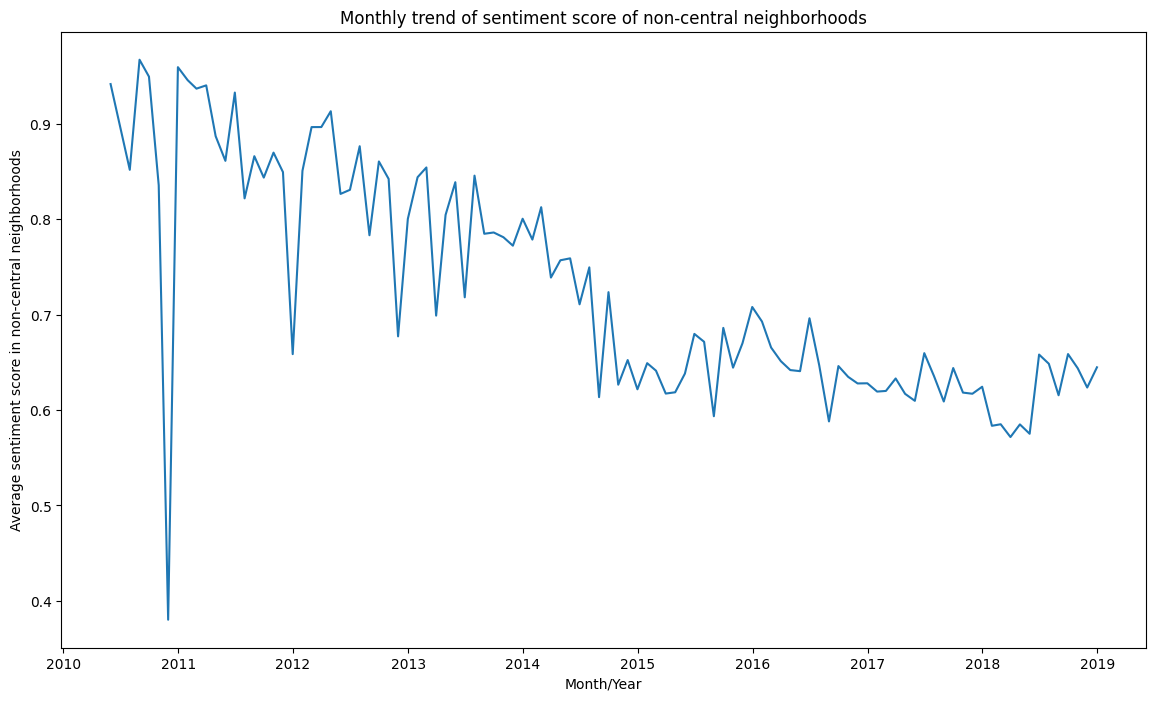

In [14]:
for batch in range(slidings):
    offset = batch * window_size + 1
    df_with_score = sdf_with_year.filter((col("RowID") >= offset) & (col("RowID") < offset + window_size)).toPandas()
    df_with_score['Date'] = pd.to_datetime(df_with_score['Date'])

    df_filtered_inner = df_with_score[~df_with_score['Neighborhood'].isin(inner)].resample('M', on='Date')['SentimentScore'].mean().reset_index()

    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df_filtered_inner, x='Date', y='SentimentScore')
    plt.title('Monthly trend of sentiment score of non-central neighborhoods')
    plt.xlabel('Month/Year')
    plt.ylabel('Average sentiment score in non-central neighborhoods')
    plt.show()
    

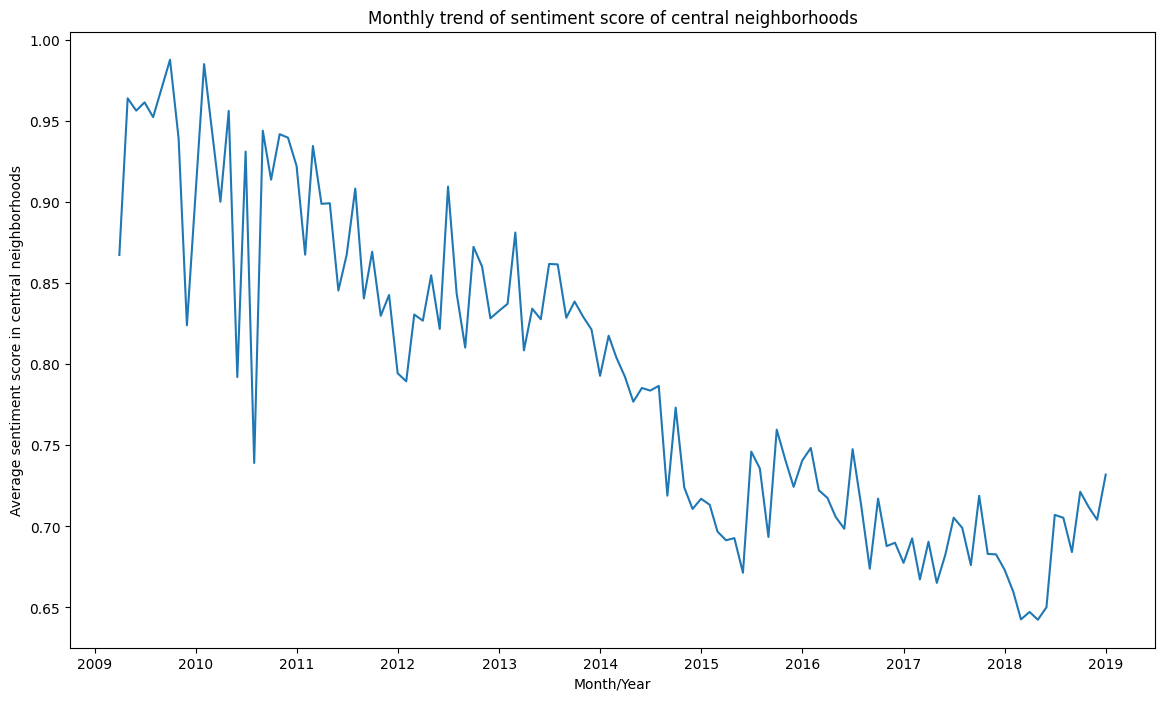

In [15]:
for batch in range(slidings):
    offset = batch * window_size + 1
    df_with_score = sdf_with_year.filter((col("RowID") >= offset) & (col("RowID") < offset + window_size)).toPandas()
    df_with_score['Date'] = pd.to_datetime(df_with_score['Date'])

    df_filtered_outer = df_with_score[df_with_score['Neighborhood'].isin(inner)].resample('M', on='Date')['SentimentScore'].mean().reset_index()

    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df_filtered_outer, x='Date', y='SentimentScore')
    plt.title('Monthly trend of sentiment score of central neighborhoods')
    plt.xlabel('Month/Year')
    plt.ylabel('Average sentiment score in central neighborhoods')
    plt.show()
    

In [ ]:
for batch in range(slidings):
    offset = batch * window_size + 1
    df_with_score = sdf_with_year.filter((col("RowID") >= offset) & (col("RowID") < offset + window_size)).toPandas()
    df_with_score['Date'] = pd.to_datetime(df_with_score['Date'])
    df_with_score['ReviewPerMonth'] = pd.to_numeric(df_with_score['ReviewPerMonth'])
    review_count_by_month = df_with_score[~df_with_score['Neighborhood'].isin(inner)].resample('M', on='Date')['ReviewPerMonth'].sum().reset_index()
    total_months = review_count_by_month['Date'].nunique()
    review_count_by_month['NormReviewPerMonth'] = review_count_by_month['ReviewPerMonth'] / total_months

    plt.figure(figsize=(14, 8))
    sns.lineplot(data=review_count_by_month, x='Date', y='NormReviewPerMonth')
    plt.title('Monthly trend of the number of reviews out of the center')
    plt.xlabel('Month/Year')
    plt.ylabel('Normalized number of review')
    plt.show()
    break

In [5]:
spark.stop()